In [1]:
from __future__ import print_function, division
import os
import sys
import numpy as np
import cv2
import sklearn
import seaborn as sns
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
import matplotlib.image as mpimg
import scipy.ndimage as ndimage
import keras
from keras.layers import *
from keras import optimizers
from keras.applications.densenet import DenseNet121
from keras import models
from keras import layers
from keras.applications import VGG16,VGG19
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import AveragePooling2D
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,GaussianNoise
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from numpy.random import random,randn
from keras.initializers import RandomNormal
from vis.visualization import visualize_cam

ModuleNotFoundError: No module named 'cv2'

In [25]:
#Dataset for training the GAN
mypath='./data/NonAugmentedTrain/COVID-19'
file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]
train_img=np.zeros([len(file_names),128, 128,1])
training_labels = []
for i, file in enumerate(file_names):
        if not os.path.exists(mypath+'/'+file):
          print('path is not correct')
        else:
          image = cv2.imread(mypath+'/'+file)
          #convert to gray scale and resize
          grayscale=np.dot(image,[0.2989,0.5870,0.1140])
          grayscale = cv2.resize(grayscale,(128, 128), interpolation = cv2.INTER_AREA)
          grayimg=np.expand_dims(grayscale,axis=-1)
          train_img[i,:,:,:]=grayimg
          training_labels.append(1)

In [26]:
#modified code from https://github.com/eriklindernoren/Keras-GAN
#Author eriklindernoren
class DCGAN():
    def __init__(self,weights):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.weights=weights

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        if(weights):
          self.discriminator.load_weights(weights)
          print('we have pretrained weights')
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()
        init = RandomNormal(mean=0.0, stddev=0.02)
        model.add(Dense(128 * 32 * 32, activation="relu",kernel_initializer=init,input_dim=self.latent_dim))
        model.add(Reshape((32, 32, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()
        init = RandomNormal(mean=0.0, stddev=0.02)
        model.add(Conv2D(128, kernel_size=3, strides=2,activation="relu",kernel_initializer=init,input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same",activation="relu"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(512, kernel_size=3, strides=2, padding="same",activation="relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(1024, kernel_size=3, strides=1, padding="same",activation="relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def generate_latent_points(self,latent_dim, n_samples):
	      # generate points in the latent space
	      x_input = randn(latent_dim * n_samples)
	      # reshape into a batch of inputs for the network
	      x_input = x_input.reshape((n_samples, latent_dim))
	      return x_input    

    def train(self,train_image, epochs, batch_size=128, save_interval=50):

        # Rescale -1 to 1
        X_train = train_image.astype(np.float32) / 127.5 - 1.

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        #one side label smoothing
        valid=valid - 0.3 + (random(valid.shape) * 0.5)
        fake = np.zeros((batch_size, 1))
        #fake=fake + random(fake.shape) * 0.3

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            #noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            noise = self.generate_latent_points(self.latent_dim,batch_size)
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = self.generate_latent_points(self.latent_dim, r*c)
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        if not os.path.exists("./data/DCGAN_images_Covid19"):
            os.makedirs("./data/DCGAN_images_Covid19")        
        fig.savefig("./data/DCGAN_images_Covid19/x_ray_%d.png" % epoch)
        plt.close()


In [27]:
dcgan = DCGAN(weights=None)
dcgan.train(train_img,epochs=10000, batch_size=32, save_interval=100)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 64, 64, 128)       1280      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 33, 33, 256)       0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 33, 33, 256)       1024      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 33, 33, 256)      

/home/tu-nonafalaki/group/bagel/Nona/conda/envs/tensorflow/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 7.606408, acc.: 0.00%] [G loss: 0.267266]


/home/tu-nonafalaki/group/bagel/Nona/conda/envs/tensorflow/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.275046, acc.: 50.00%] [G loss: 9.602562]
2 [D loss: 0.333596, acc.: 50.00%] [G loss: 8.483572]
3 [D loss: 0.425324, acc.: 50.00%] [G loss: 4.730648]
4 [D loss: 0.194551, acc.: 50.00%] [G loss: 5.739153]
5 [D loss: 0.377696, acc.: 50.00%] [G loss: 7.760808]
6 [D loss: 0.296096, acc.: 50.00%] [G loss: 6.298060]
7 [D loss: 0.235161, acc.: 50.00%] [G loss: 6.449459]
8 [D loss: 0.163527, acc.: 50.00%] [G loss: 3.578132]
9 [D loss: 0.250857, acc.: 48.44%] [G loss: 4.100174]
10 [D loss: 0.166186, acc.: 50.00%] [G loss: 4.383749]
11 [D loss: 0.212090, acc.: 50.00%] [G loss: 3.680471]
12 [D loss: 0.167668, acc.: 50.00%] [G loss: 6.854746]
13 [D loss: 2.891596, acc.: 0.00%] [G loss: 27.229267]
14 [D loss: 2.724350, acc.: 50.00%] [G loss: 6.796615]
15 [D loss: 1.462069, acc.: 29.69%] [G loss: 21.051025]
16 [D loss: 0.433378, acc.: 50.00%] [G loss: 31.194324]
17 [D loss: 4.070886, acc.: 50.00%] [G loss: 0.189008]
18 [D loss: 5.138416, acc.: 1.56%] [G loss: 19.736576]
19 [D loss: 1.322

In [28]:
#generate 1000 synthetic samples
noise = np.random.normal(0, 1, (1000, 100))
gen_imgs = dcgan.generator.predict(noise)

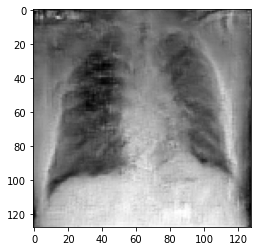

In [29]:
#plot generated images
plt.imshow(gen_imgs[499][:,:,0],cmap='gray')

In [ ]:
#save generated images
for i in range(gen_imgs.shape[0]):
  if not os.path.exists("./data/DCGAN/generated_images_COVID19_1000"):
            os.makedirs("./data/DCGAN/generated_images_COVID19_1000")  
  matplotlib.image.imsave("./data/DCGAN/generated_images_COVID19_1000/generated_x_ray_%d.png" % i,gen_imgs[i][:,:,0],cmap='gray')

In [30]:
#Dataset for training the classifiers(500 fake + 500 real samples)
dataDir = "./data/Train_1000perclass"
categories = ["Normal","Bacterial","Viral_800","COVID-19"]
imgSize=94
trainingData = []
labels=[]
for category in categories:
    classIndex = categories.index(category)
    categoryDir = category
    path = os.path.join(dataDir, categoryDir)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (imgSize, imgSize))
        image = img_to_array(new_array)
        trainingData.append(image)
        labels.append(classIndex)

Total number of data in each folder of TrainData

COVID-19:1000
Viral_800:800
Normal:1000
Bacterial:1000
.ipynb_checkpoints:0


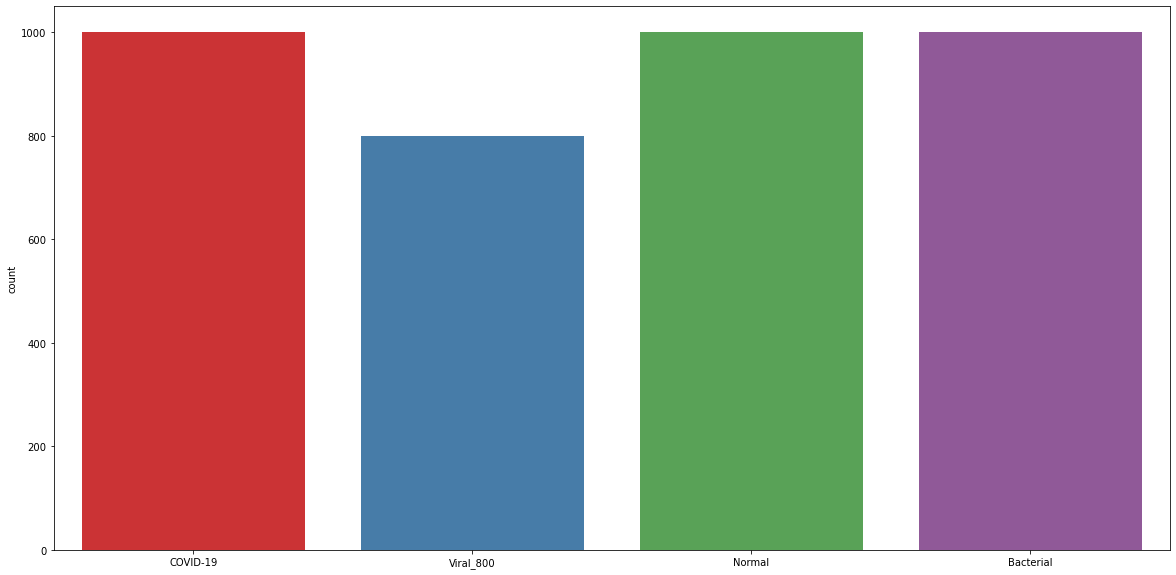

In [53]:
#plot dataset distribution
samples = []
datadir = './data/Train_1000perclass'
print("Total number of data in each folder of TrainData\n")
for filename in os.listdir(datadir): 
        path = os.path.join(datadir, filename) 
        list = os.listdir(path) 
        num_files = len(list)
        samples.extend([filename]*num_files)
        print (filename + ":"+ str(num_files))
plt.figure(figsize=(20,10))        
sns.countplot(samples,palette="Set1")
plt.show()

In [57]:
#split dataset to 30% validation and 20% test
trainingData = np.array(trainingData, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
X, X_test,y, y_test = train_test_split(trainingData, labels, test_size=0.2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True)

In [58]:
#vgg19 model

conv_base = VGG19(weights='imagenet',include_top=False, input_shape=(imgSize, imgSize, 3))
headModel = conv_base.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=conv_base.input, outputs=headModel)

# loop over all layers in the base model and make them trainable
for layer in conv_base.layers:
    layer.trainable = True
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0002,decay=0.0001 / 15),
              metrics=['accuracy']) 
model.summary()                  

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 94, 94, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 94, 94, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 94, 94, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 47, 47, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 47, 47, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 47, 47, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 23, 23, 128)       0  

In [66]:
#train model
history = model.fit(X_train, 
                     y_train, 
                     validation_data=[X_val,y_val],
                     batch_size= 64, 
                     epochs = 20)

Train on 2128 samples, validate on 912 samples
Epoch 1/20
2128/2128 [==============================] - 4s 2ms/step - loss: 0.0710 - accuracy: 0.9807 - val_loss: 0.3811 - val_accuracy: 0.9211
Epoch 2/20
2128/2128 [==============================] - 4s 2ms/step - loss: 0.0310 - accuracy: 0.9915 - val_loss: 0.4479 - val_accuracy: 0.9046
Epoch 3/20
2128/2128 [==============================] - 4s 2ms/step - loss: 0.0318 - accuracy: 0.9897 - val_loss: 0.3997 - val_accuracy: 0.9156
Epoch 4/20
2128/2128 [==============================] - 4s 2ms/step - loss: 0.0360 - accuracy: 0.9892 - val_loss: 0.5038 - val_accuracy: 0.9178
Epoch 5/20
2128/2128 [==============================] - 4s 2ms/step - loss: 0.0133 - accuracy: 0.9958 - val_loss: 0.5843 - val_accuracy: 0.9178
Epoch 6/20
2128/2128 [==============================] - 4s 2ms/step - loss: 0.0114 - accuracy: 0.9962 - val_loss: 0.5239 - val_accuracy: 0.9156
Epoch 7/20
2128/2128 [==============================] - 4s 2ms/step - loss: 0.0246 - accu

Text(0.5, 145.31999999999996, 'Predicted')

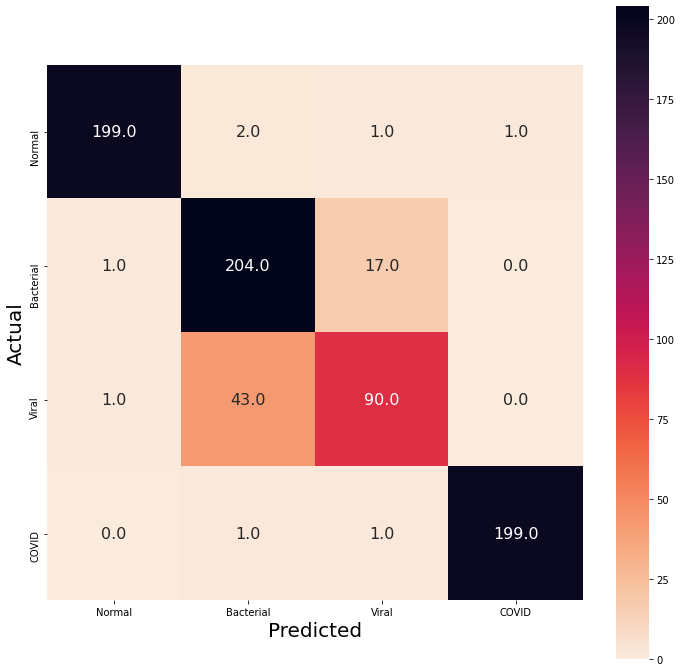

In [67]:
#confusion_matrix on testset
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
ytrue = np.argmax(y_test, axis=1)
labels = ["Normal","Bacterial","Viral","COVID"]
confMatrix = confusion_matrix(ytrue, y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(confMatrix, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True,xticklabels=labels, yticklabels=labels)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [68]:
# make predictions on the testing set
pred = model.predict(X_test, batch_size=25)
pred = np.argmax(pred, axis=1)
print(classification_report(y_test.argmax(axis=1), pred,target_names=labels))

              precision    recall  f1-score   support

      Normal       0.99      0.98      0.99       203
   Bacterial       0.82      0.92      0.86       222
       Viral       0.83      0.67      0.74       134
       COVID       0.99      0.99      0.99       201

    accuracy                           0.91       760
   macro avg       0.91      0.89      0.90       760
weighted avg       0.91      0.91      0.91       760



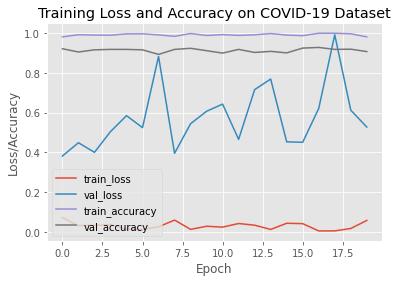

In [83]:
#plot
epochs = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [70]:
#print layers for saliency map
for ilayer, layer in enumerate(model.layers):
    print("{:3.0f} {:10}".format(ilayer, layer.name))

  0 input_17  
  1 block1_conv1
  2 block1_conv2
  3 block1_pool
  4 block2_conv1
  5 block2_conv2
  6 block2_pool
  7 block3_conv1
  8 block3_conv2
  9 block3_conv3
 10 block3_conv4
 11 block3_pool
 12 block4_conv1
 13 block4_conv2
 14 block4_conv3
 15 block4_conv4
 16 block4_pool
 17 block5_conv1
 18 block5_conv2
 19 block5_conv3
 20 block5_conv4
 21 block5_pool
 22 flatten   
 23 dense_13  
 24 dropout_22
 25 dense_14  


In [80]:
#saliency map
#modified code from https://medium.com/@ODSC/visualizing-your-convolutional-neural-network-predictions-with-saliency-maps-9604eb03d766

classlabel= ["Normal","Bacterial","Viral","COVID-19"]
img_index = 300
img=X_test[img_index]
layer_idx = utils.find_layer_idx(model, 'dense_14')
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

In [81]:
grads=visualize_saliency(model,layer_idx,filter_indices=None,seed_input=img,backprop_modifier=None,grad_modifier='absolute')
y_pred            = model.predict(img[np.newaxis,...])
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
for i, idx in enumerate(class_idxs_sorted[:4]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,y_pred[0,idx]))
print('true label:',y_test[img_index])

Top 1 predicted class:     Pr(Class=Normal             [index=0])=53.768
Top 2 predicted class:     Pr(Class=COVID-19           [index=3])=-2.154
Top 3 predicted class:     Pr(Class=Viral              [index=2])=-2.364
Top 4 predicted class:     Pr(Class=Bacterial          [index=1])=-25.241
true label: [1 0 0 0]


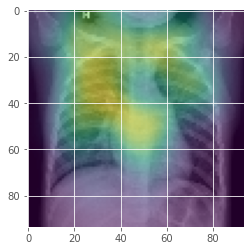

In [82]:
gaus=ndimage.gaussian_filter(grads[:,:,2],sigma=5)
plt.imshow(img[:,:,0],cmap='gray')
plt.imshow(gaus,alpha=.5)

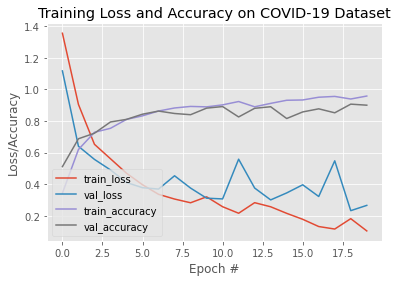

In [48]:
#plot
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [8]:
#Densnet with cheXNet weights
local_weights_file = './CheXNet_Keras_0.3.0_weights.h5/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'
base_model1=DenseNet121(include_top=False, weights= None,  input_shape=(94,94,3), pooling='avg')
base_model1.trainable = False
base_model1.load_weights(local_weights_file, by_name=True)
for layer in base_model1.layers:
      layer.trainable=False

#x = Dense(128, activation='relu')(base_model1.output)
x=Dropout(0.5)(base_model1.output)
x = Dense(4, activation='softmax')(x)
transfer_model = Model(base_model1.input, x) 
transfer_model.compile(optimizer = optimizers.Adam(lr=0.002,decay=0.001 / 15), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
transfer_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 94, 94, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 100, 100, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 47, 47, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 47, 47, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [9]:
#train model
import keras
es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
history1 = transfer_model.fit(X_train, 
                     y_train, 
                     validation_data=[X_val,y_val],
                     batch_size= 64, 
                     epochs = 35,shuffle=True,callbacks=[es_callback])

Train on 2128 samples, validate on 912 samples
Epoch 1/35
2128/2128 [==============================] - 18s 8ms/step - loss: 1.4460 - accuracy: 0.3388 - val_loss: 1.8557 - val_accuracy: 0.3761
Epoch 2/35
2128/2128 [==============================] - 2s 1ms/step - loss: 1.1552 - accuracy: 0.4962 - val_loss: 1.5501 - val_accuracy: 0.3662
Epoch 3/35
2128/2128 [==============================] - 2s 1ms/step - loss: 1.0337 - accuracy: 0.5569 - val_loss: 1.3593 - val_accuracy: 0.4737
Epoch 4/35
2128/2128 [==============================] - 2s 1ms/step - loss: 1.0014 - accuracy: 0.5644 - val_loss: 1.2213 - val_accuracy: 0.5154
Epoch 5/35
2128/2128 [==============================] - 2s 1ms/step - loss: 0.9623 - accuracy: 0.6010 - val_loss: 1.2431 - val_accuracy: 0.5263
Epoch 6/35
2128/2128 [==============================] - 2s 1ms/step - loss: 0.9230 - accuracy: 0.6123 - val_loss: 1.2656 - val_accuracy: 0.4846
Epoch 7/35
2128/2128 [==============================] - 2s 1ms/step - loss: 0.9104 - acc

In [15]:
# serialize model to JSON
model_json = transfer_model.to_json()
with open("DensNetmodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
transfer_model.save_weights("DensNetmodel.h5")
print("Saved model to disk")

Saved model to disk


In [3]:
# load json and create model
from keras.models import model_from_json
json_file = open('DensNetmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
transfer_model = model_from_json(loaded_model_json)
# load weights into new model
transfer_model.load_weights("DensNetmodel.h5")
print("Loaded model from disk")

Loaded model from disk


In [29]:
# make predictions on the testing set
catLabel = ["Normal","Bacterial","Viral","COVID"]
predIdxs = transfer_model.predict(X_test, batch_size=25)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(y_test.argmax(axis=1), predIdxs,target_names=catLabel))

[INFO] evaluating network...
              precision    recall  f1-score   support

      Normal       0.48      0.99      0.65       198
   Bacterial       0.59      0.43      0.50       202
       Viral       0.85      0.11      0.20       150
       COVID       0.91      0.81      0.86       210

    accuracy                           0.62       760
   macro avg       0.71      0.59      0.55       760
weighted avg       0.70      0.62      0.58       760



Text(0.5, 145.31999999999996, 'Predicted')

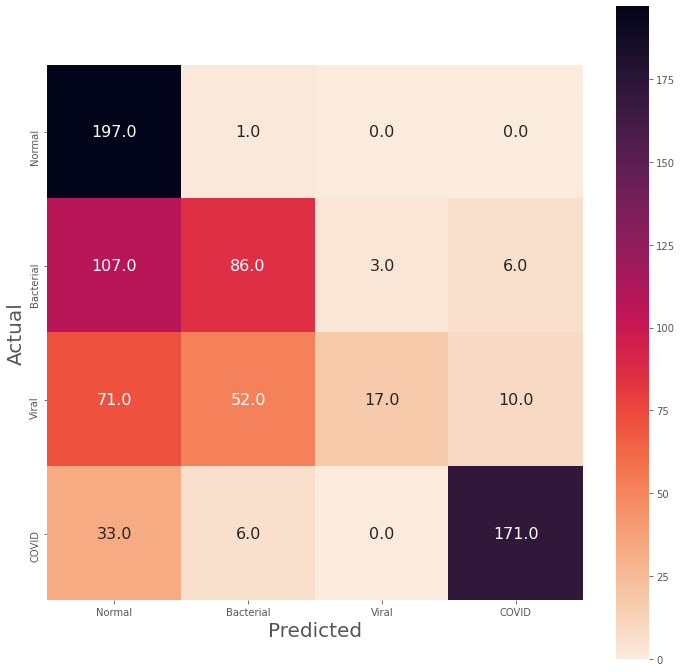

In [30]:
#confusion_matrix on testset
y_pred = transfer_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
ytrue = np.argmax(y_test, axis=1)
catLabel = ["Normal","Bacterial","Viral","COVID"]
confMatrix = confusion_matrix(ytrue, y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(confMatrix, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True,xticklabels=catLabel, yticklabels=catLabel)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [5]:
from vis.utils import utils
layer_idx = utils.find_layer_idx(transfer_model,'dense_4')

In [9]:
#code from https://fairyonice.github.io/Grad-CAM-with-keras-vis.html
def plot_map(grads,img):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(img[:,:,0],cmap='gray')
    axes[1].imshow(img[:,:,0],cmap='gray')
    i = axes[1].imshow(grads,cmap="jet",alpha=0.5)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f}".format(
                      classlabel[class_idx],
                      y_pred[0,class_idx])) 

In [12]:
imgn=[150]
for imgnum in imgn:

    transfer_model.layers[layer_idx].activation = keras.activations.softmax
    transfer_model = utils.apply_modifications(transfer_model)
    img               = img_to_array(X_test[imgnum])
    #img               = preprocess_input(img)
    classlabel= ["Normal","Bacterial","Viral","COVID-19"]
    y_pred            = transfer_model.predict(img[np.newaxis,...])
    class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
    topclass         = 4
    for i, idx in enumerate(class_idxs_sorted[:topclass]):
        print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
              i + 1,classlabel[idx],idx,y_pred[0,idx]))
    print('true label:',y_test[imgnum])  
    penultimate_layer_idx = utils.find_layer_idx(transfer_model, "bn") 
    class_idx  = class_idxs_sorted[0]
    transfer_model.layers[layer_idx].activation = keras.activations.linear
    transfer_model = utils.apply_modifications(transfer_model)
    seed_input = img
    grad1  = visualize_cam(transfer_model, layer_idx, class_idx, seed_input, 
                             penultimate_layer_idx = penultimate_layer_idx,#None,
                             backprop_modifier     = None,
                             grad_modifier         = None)

Top 1 predicted class:     Pr(Class=COVID-19           [index=3])=0.400
Top 2 predicted class:     Pr(Class=Normal             [index=0])=0.346
Top 3 predicted class:     Pr(Class=Bacterial          [index=1])=0.231
Top 4 predicted class:     Pr(Class=Viral              [index=2])=0.024
true label: [0 0 0 1]


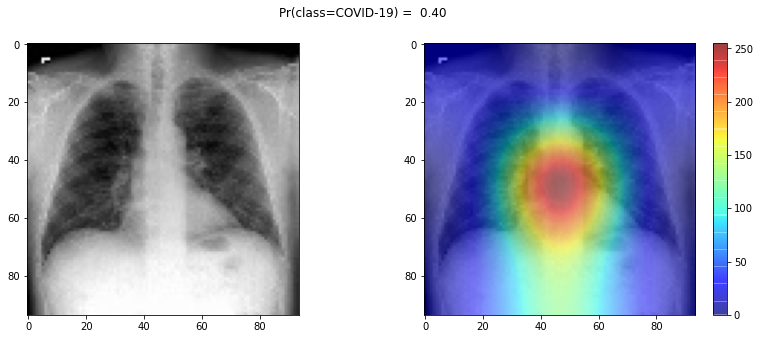

In [13]:
#Bacterial
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(img[:,:,0],cmap='gray')
    axes[1].imshow(img[:,:,0],cmap='gray')
    i = axes[1].imshow(grads,cmap="jet",alpha=0.5)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f}".format(
                      classlabel[class_idx],
                      y_pred[0,class_idx]))
plot_map(grad1)

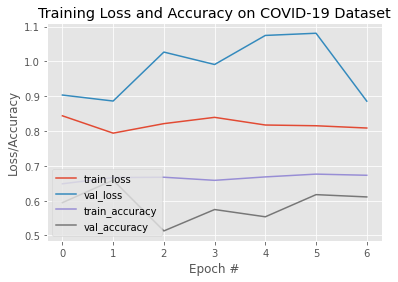

In [32]:
#plot
Epochs = 7
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, Epochs), history1.history["loss"], label="train_loss")
plt.plot(np.arange(0, Epochs), history1.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, Epochs), history1.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, Epochs), history1.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")